In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant libraries for creating a pipeline
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import set_config

set_config(transform_output="pandas")

In [3]:
df = pd.read_csv("./dataset/asteroid_training.csv")
unknown_objects = pd.read_csv("./dataset/unknown_asteroids.csv")

In [4]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,26150198,Object_26150198,0.031956,0.071456,75374.759095,1.070689e+06,Earth,False,24.60,False
1,7025688,Object_7025688,0.133216,0.297879,33274.114790,1.598217e+07,Earth,False,21.50,False
2,43368461,Object_43368461,0.043507,0.097284,74702.349802,2.330585e+06,Earth,False,23.93,False
3,41099354,Object_41099354,0.012149,0.027167,33078.313997,4.561178e+07,Earth,False,26.70,False
4,25572576,Object_25572576,0.058151,0.130029,51956.093518,3.613123e+06,Earth,False,23.30,False


In [5]:
# Check the shape of the dataframe
print(df.shape)

(9083, 10)


In [6]:
# Check for duplicates and remove duplicates if there are
print(df.duplicated().sum())

df = df[~df.duplicated()]
print(df.duplicated().sum())

0
0


In [7]:
df.describe(include="all")

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
count,9.083000e+03,9083,9083.000000,9083.000000,9083.000000,9.083000e+03,9083,9083,9083.000000,9083
unique,NaN,9083,NaN,NaN,NaN,NaN,1,1,NaN,2
top,NaN,Object_26150198,NaN,NaN,NaN,NaN,Earth,False,NaN,False
freq,NaN,1,NaN,NaN,NaN,NaN,9083,9083,NaN,8247
mean,2.515456e+07,NaN,0.125683,0.281035,47658.171830,3.696279e+07,NaN,NaN,23.568789,NaN
std,1.424013e+07,NaN,0.335222,0.749580,25006.496725,2.217602e+07,NaN,NaN,2.878480,NaN
min,5.096120e+05,NaN,0.000818,0.001828,494.185355,1.367200e+04,NaN,NaN,10.310000,NaN
25%,1.286088e+07,NaN,0.019256,0.043057,28374.520110,1.712688e+07,NaN,NaN,21.400000,NaN
50%,2.516307e+07,NaN,0.048368,0.108153,44023.051894,3.819473e+07,NaN,NaN,23.700000,NaN
75%,3.757898e+07,NaN,0.139494,0.311918,62433.931810,5.596681e+07,NaN,NaN,25.700000,NaN


In [8]:
# Confirm the datatypes
print(df.dtypes)

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object


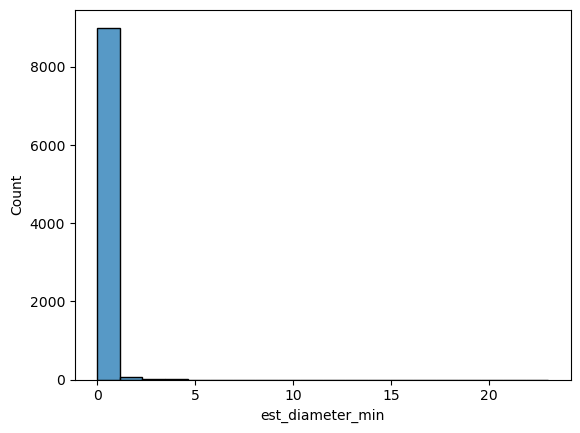

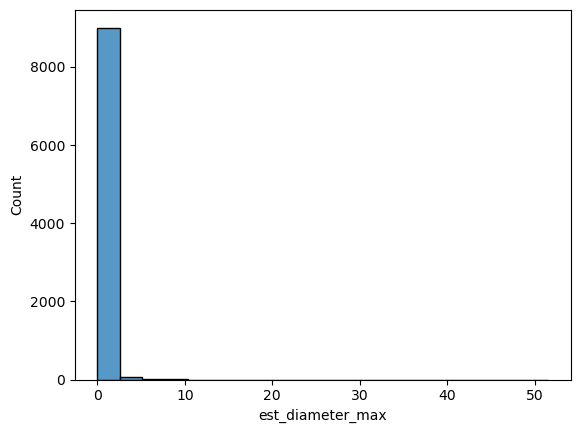

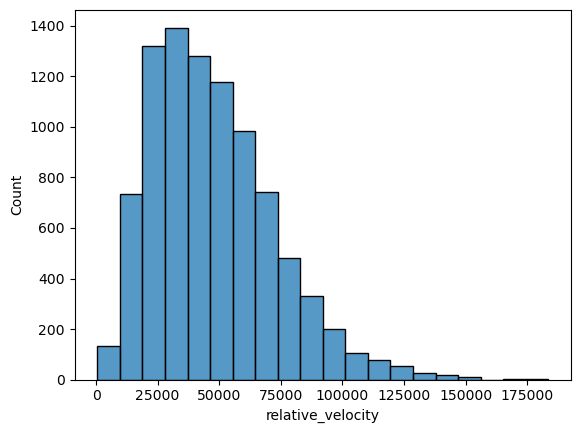

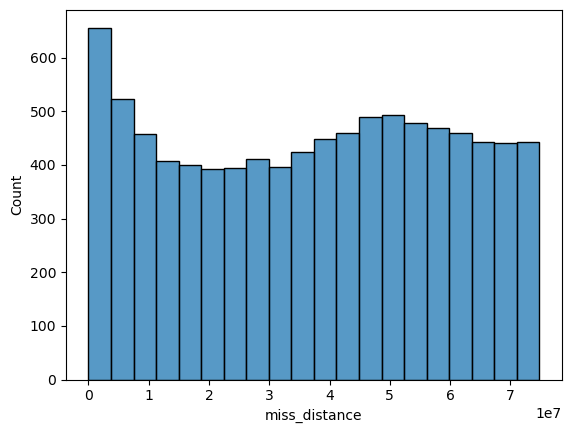

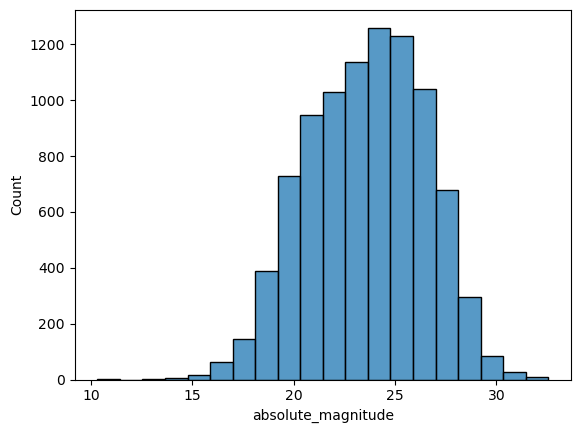

In [9]:
# numeric_cols = df.select_dtypes(include=["number"]).columns

# Check the distribution across all relevant numeric columns
numeric_cols = ['est_diameter_min', 'est_diameter_max', 'relative_velocity',
       'miss_distance', 'absolute_magnitude']

for col in numeric_cols:
    sns.histplot(data=df, x=col, bins=20)
    plt.show()

In [10]:
# Both diameters will require log normalization
class LogTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns = X.columns
        if isinstance(X, pd.Series):
            self.columns = [X.name]
        if isinstance(X, np.ndarray):
            raise TypeError("X must be a pandas DataFrame or Series")
        return self

    def transform(self, X):
        return np.log(X)

    def get_feature_names_out(self):
        return self.columns

{}


<Axes: ylabel='Count'>

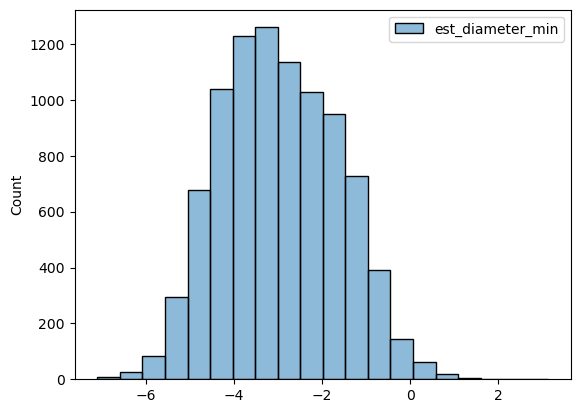

In [11]:
log_transformer = LogTransformer()
print(log_transformer.get_params())
log_transformed_min_diameter = log_transformer.fit_transform(df['est_diameter_min'])
sns.histplot(log_transformed_min_diameter, bins=20)

In [12]:
# Check if the sentry_object property has both positive and negative.
# This will inform whether or not to use it in the model

print(df["sentry_object"].value_counts())

sentry_object
False    9083
Name: count, dtype: int64


In [13]:
# Check the distribution of the hazardous property.
# This will inform how to split the data using train_test_split

print(df["hazardous"].value_counts())

hazardous
False    8247
True      836
Name: count, dtype: int64


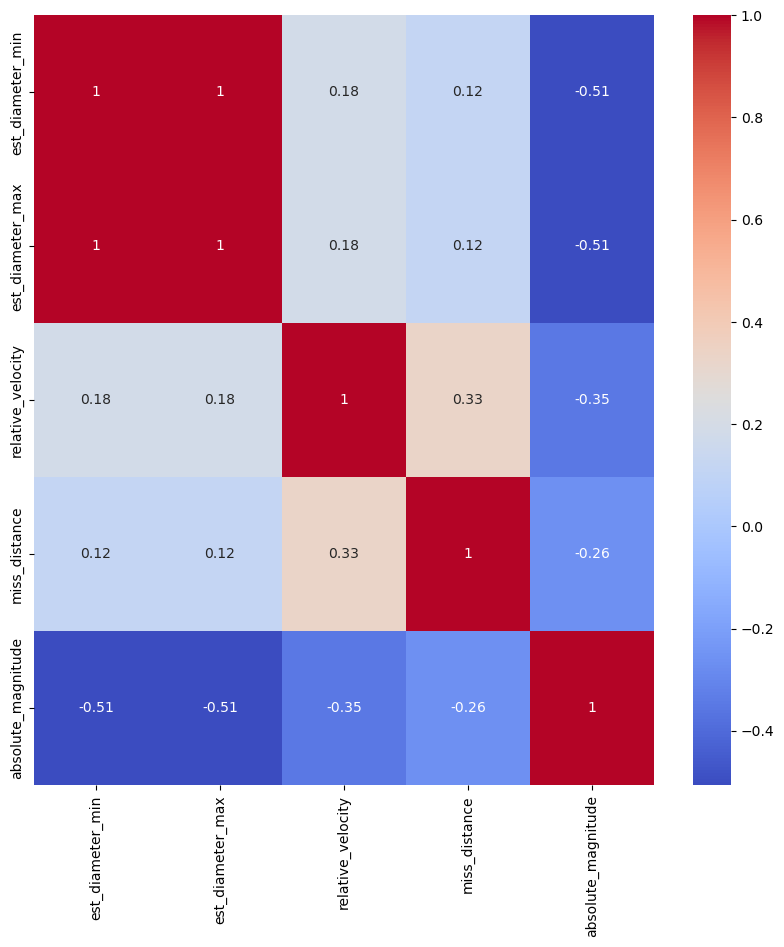

In [14]:
# Check for collinearity across the numeric columns

corr_matrix = df[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=ax)
plt.show()

In [15]:
X = df.drop(columns=["hazardous"])
y = df["hazardous"]

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

hazardous
False    0.906826
True     0.093174
Name: proportion, dtype: float64
hazardous
False    0.912493
True     0.087507
Name: proportion, dtype: float64


In [16]:
# Preprocessing Transformer
scaling_encoding_pipeline = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", ["est_diameter_min", "id", "name", "sentry_object"]),
        ("numeric", StandardScaler(), ["est_diameter_max", 'relative_velocity', 'miss_distance', 'absolute_magnitude']),
        ("categorical", OneHotEncoder(sparse_output=False), ["orbiting_body", "sentry_object"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# log_transform_pipe = ColumnTransformer(
#     transformers=[
#         ("log_transform", LogTransformer(), ["est_diameter_max"])
#     ],
#     remainder="passthrough",
#     verbose_feature_names_out=False
# )

# Full Processing Pipelin
preprocessing_pipeline = Pipeline(
    steps=[
        ("scale_encode", scaling_encoding_pipeline),
        # ("log_transform", log_transform_pipe),
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

In [17]:
logistic_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessing_pipeline),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]
)

cross_val_score(logistic_pipeline, X_train, y_train, cv=5, scoring="f1_macro").mean()

0.5231411115158848

In [18]:
# Enhance model performance using Cross Validation
param_grid = {
    "classifier__C": [0.1, 1, 10, 100, 1000],
    "classifier__penalty": ["l1", "l2"],
    "classifier__class_weight": ["balanced", None],
    "preprocessing__imputer__strategy": ["mean", "median"],
    "classifier__solver": ["liblinear"]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(logistic_pipeline, param_distributions=param_grid, n_iter=80, cv=5, scoring="accuracy")
random_search.fit(X_train, y_train)

C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 40 is smaller than n_iter=80. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('scale_encode',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('drop_features',
                                                                                                'drop',
                                                                                                ['est_diameter_min',
                                                                                                 'id',
                                                                                                 'name',
                                                                                                 'sentry_object']),
                                                                                               ('numeric',
                                                                                                StandardScaler(),
                                                                                                ['est_diameter_max',
                                                                                                 'relative_velocity',
                                                                                                 'miss_distance',
                                                                                                 'absolute_magnitude']),
                                                                                               ('categorical'...
                                                              ('imputer',
                                                               SimpleImputer())])),
                                             ('classifier',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=80,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100,
                                                          1000],
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear'],
                                        'preprocessing__imputer__strategy': ['mean',
                                                                             'median']},
                   scoring='accuracy')

In [19]:
print(random_search.best_score_)

0.9079283860835288


In [20]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
print((f1, accuracy))

(0.5400340820686333, 0.9097413318657127)


In [21]:
y_pred_new_samples = random_search.predict(unknown_objects)
res = pd.DataFrame(y_pred_new_samples, columns=["hazardous"])

print(res.value_counts())
print(res.value_counts(normalize=True))

hazardous
False        1484
True           16
Name: count, dtype: int64
hazardous
False        0.989333
True         0.010667
Name: proportion, dtype: float64
